In [1]:
import numpy as np
from matplotlib import pyplot as plt

the long-awaited power spectrum function

In [2]:
twopi=2*np.pi

def P(T, sp_type, Lsurvey, Npix):
    '''
    T       = Lsurvey-x-Lsurvey-x-Lsurvey data box for which you wish to create the power spectrum
    sp_type = for now, only 'log' and 'lin' are supported ... spacing scheme for r-bins
    Lsurvey = side length of the simulation cube (Mpc)
    Npix    = number of bins per side of the simulation cube
    '''
    # helper variables
    Delta = Lsurvey/Npix # voxel side length
    rmax=Lsurvey/2
    if (sp_type=='log'):
        k=np.logspace(np.log10(twopi/Npix),np.log10(twopi/Lsurvey),num=Npix) #NEW VERSION
    elif (sp_type=='lin'):
        r=np.linspace(0,rmax,Npix+2)
    else:
        print('ERROR: UNSUPPORTED VOXEL SPACING SCHEME')
        assert(sp_type=='log' or sp_type=='lin') # MEDIUM-TERM GOAL: ACCOMMODATE MORE EXOTIC SPACING SCHEMES
    dr3 = Delta**3 # size of voxel
    
    # process the box values
    Ts = np.fft.ifftshift(T)*dr3 # T-ishifted (np wants a corner origin; ishift takes you there)
    Tts = np.fft.fftn(Ts) # T-tilde
    Tt = np.fft.fftshift(Tts) # shift back to physics land
    mTt = Tt*np.conjugate(Tt) # mod-squared of Tt # IMSHOW LOOKS GOOD
    mTt = mTt.real # I checked, and there aren't even any machine precision issues in the imag part
    
    # prepare to tie the processed box values to relevant k-values (generate k-quantities)
    Kshuf=twopi*np.fft.fftshift(np.fft.fftfreq(Lsurvey,d=Delta)) # fftshift not just for amplitudes
    KX,KY,KZ=np.meshgrid(Kshuf,Kshuf,Kshuf)
    kmags=np.sqrt(KX**2+KY**2+KZ**2)
    binidxs=np.digitize(kmags,k,right=False) # IMSHOW LOOKS GOOD

    # identify which box each point falls into
    amTt=np.zeros(Npix)
    for i,binedge in enumerate(k):
        here=np.nonzero(i==binidxs) # WANT all box indices where the corresp bin index is the ith binedge (nonzero is like argwhere, but gives output that is suitable for indexing arrays)
        if (len(here[0])>0): # already know len(here) = arr_dimns, so check for emptiness w/ len(here[0])
            amTt[i]=np.mean(mTt[here])
        else:
            amTt[0]=0

    V = Lsurvey**3 # volume of the simulation cube
    return [np.array(k),np.array(amTt/V)]

In [3]:
# def ps_userbin(T, kbins, Lsurvey, Npix):
#     '''
#     T       = Lsurvey-x-Lsurvey-x-Lsurvey data box for which you wish to create the power spectrum
#     kbins   = user-defined (if using this wrapper function, then probably custom-spaced) VECTOR of k-bins
#     Lsurvey = side length of the simulation cube (Mpc)
#     Npix    = number of **bins** per side of the simulation cube
#     '''
#     return P(T,kbins,Lsurvey,Npix)

# def ps_autobin(T, mode, kmin, kmax, Lsurvey, Npix):
#     '''
#     T       = Lsurvey-x-Lsurvey-x-Lsurvey data box for which you wish to create the power spectrum
#     mode    = binning mode (linear or logarithmic)
#     kmin    = smallest k-mode for which the power spectrum is defined
#     kmax    = largest k-mode for which the power spectrum is defined 
#     Lsurvey = side length of the simulation cube (Mpc)
#     Npix    = number of **bins** per side of the simulation cube
#     '''
#     kmin=twopi/Lsurvey
#     Delta=Lsurvey/Npix
#     kmax=twopi/Delta
#     assert (mode=='lin' or mode=='log'), 'only linear and logarithmic auto-generated bins are currently support'
#     assert kmax>kmin, 'kmax must be strictly greater than kmin'
#     if (mode=='log'):
#         k=np.logspace(kmin,kmax,num=Npix+2)
#     else:
#         k=np.linspace()
#     return None

white noise test

In [4]:
Lsurvey = 100
Npix = 12
T = np.random.normal(loc=0.0, scale=1.0, size=(Lsurvey,Lsurvey,Lsurvey))

# kfloors,vals=ps_autobin(T, 'log', Lsurvey, Npix)

kfloors,vals=P(T,'log',Lsurvey,Npix)

In [5]:
print(kfloors.shape)
print(vals.shape)

(12,)
(12,)


In [6]:
# plt.imshow(T[:,:,5])
# plt.colorbar()
# plt.show()
# plt.imshow(T[:,:,13])
# plt.colorbar()
# plt.show()

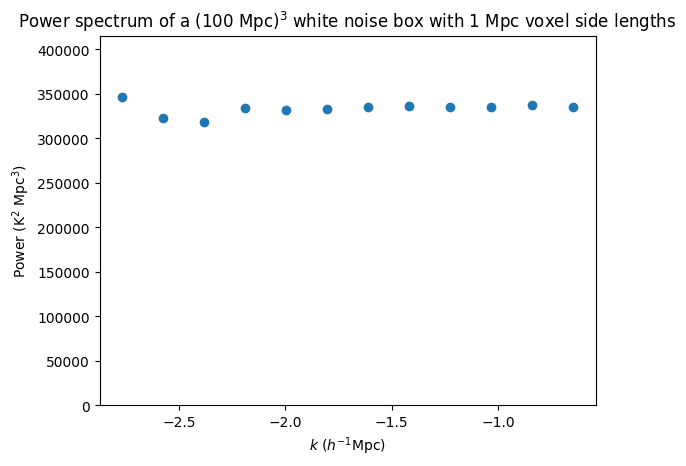

In [7]:
plt.scatter(np.log(kfloors),vals)
plt.xlabel('$k$ ($h^{-1}$Mpc)')
plt.ylabel('Power (K$^2$ Mpc$^3$)')
plt.title('Power spectrum of a (100 Mpc)$^3$ white noise box with 1 Mpc voxel side lengths')
plt.ylim(0,1.2*max(vals))
plt.show()

In [8]:
np.savetxt('ps_wn_20px.txt',np.array([kfloors,vals]).T)

This is just one realization. Technically, the power spectrum is only valid in the infinite ensemble average. But, we will develop an even better understanding of the current algorithm's performance by averaging over a handful (say, 10, to start with) of cases. This will be helpful towards deciding whether there are lingering mistakes in my implementation or whether the apparent fluctuations present in a given realization are merely due to cosmic variance. 

In [9]:
nrealizations=25
allps=np.zeros([Npix,nrealizations])
for i in range(nrealizations):
    T = np.random.normal(loc=0.0, scale=1.0, size=(Lsurvey,Lsurvey,Lsurvey))
    kfls,values=P(T,'log',Lsurvey,Npix)
    allps[:,i]=values

In [10]:
print(allps.shape)
meanps=np.mean(allps,axis=1)

(12, 25)


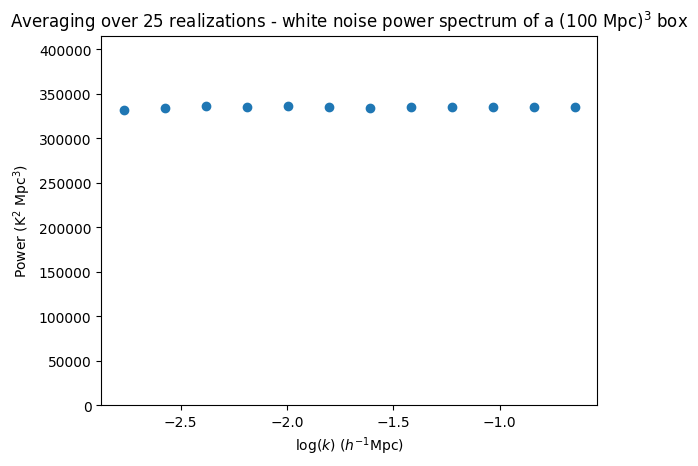

In [11]:
plt.scatter(np.log(kfls),meanps)
plt.xlabel('$\log(k)$ ($h^{-1}$Mpc)')
plt.ylabel('Power (K$^2$ Mpc$^3$)')
plt.title('Averaging over '+str(nrealizations)+' realizations - white noise power spectrum of a (100 Mpc)$^3$ box')
plt.ylim(0,1.2*max(vals))
plt.show()
np.savetxt('meanps_10rz_20px.txt',meanps)

21cmFast example

In [12]:
zs=[5,6,7,8,9,10]
pstart='./sample_boxes_21cmfast/'
allzs21=[]

for z in zs:
    T21=np.load(pstart+'a_box_z_'+str(z)+'.npy')
    Lsurv21=100
    Nbins21=10
    r21 = np.logspace(-1,1.7,num=Nbins21)

    kfloors21,vals21=P(T21,'log',Lsurv21,Nbins21)
    allzs21.append([kfloors21,vals21])

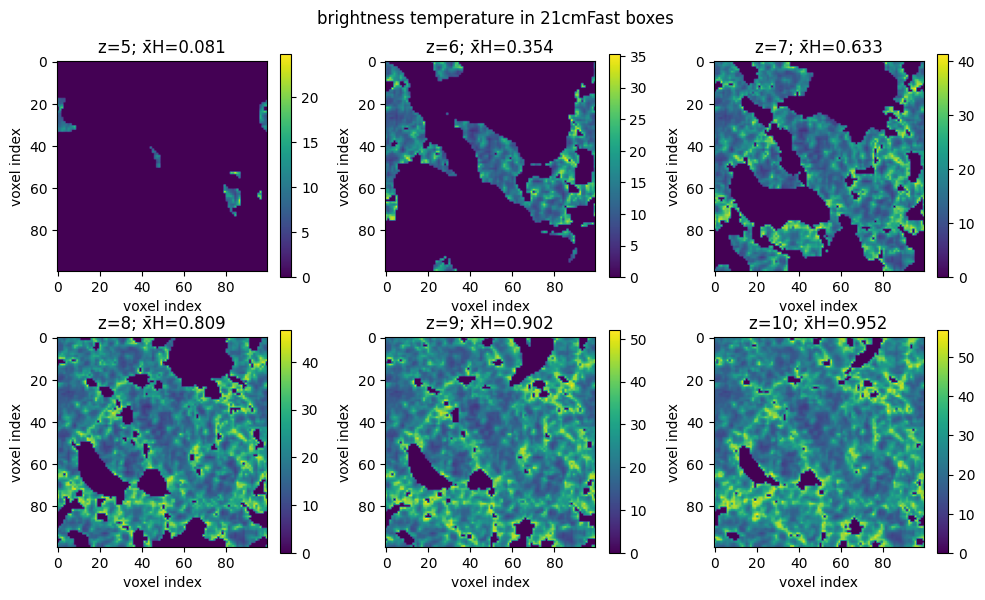

In [13]:
zs=['5','6','7','8','9','10']
xHs=[]
fig,axs=plt.subplots(2,3,figsize=(10,6))
i=0
j=0
for z in zs:
    box=np.load(pstart+'a_box_z_'+z+'.npy')
    xH=np.count_nonzero(box)/(100**3)
    xHs.append(xH)
    imcurr=axs[i][j].imshow(box[:,:,50])
    fig.colorbar(imcurr)
    axs[i][j].set_xlabel('voxel index')
    axs[i][j].set_ylabel('voxel index')
    axs[i][j].set_title('z='+str(z)+'; x̄H='+str(round(xH,3)))
    if (j==2):
        i=1
        j=0
    else:
        j+=1
    

fig.suptitle('brightness temperature in 21cmFast boxes')
fig.tight_layout()
plt.show()

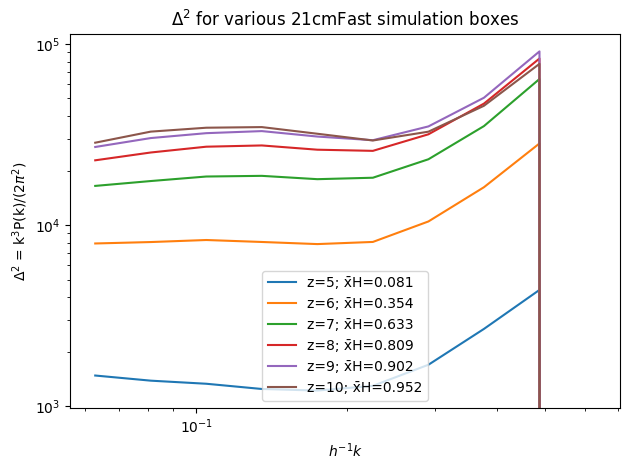

In [14]:
for i,z in enumerate(allzs21):
    kfloors21,vals21=z
    plt.loglog(kfloors21,kfloors21**3*vals21/(2*np.pi**2),label='z='+str(zs[i])+'; x̄H='+str(round(xHs[i],3)))

plt.xlabel('$h^{-1}k$')
plt.ylabel('$\Delta^2$ = k$^3$P(k)/(2$\pi^2$)')
plt.title('$\Delta^2$ for various 21cmFast simulation boxes')
plt.legend()
plt.tight_layout()
plt.show()